<a href="https://colab.research.google.com/github/saipuneet357/AutoEncoders/blob/main/build_denoiserAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import pandas as pd

In [3]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 1

In [4]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

In [5]:
from google.colab import drive

In [6]:
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [7]:
location = '/content/gdrive/MyDrive/NotMnist'  

In [8]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

In [9]:
train_data = extract_data(location+'/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data(location+'/t10k-images-idx3-ubyte.gz', 10000)

In [10]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [11]:
train_labels = extract_labels(location+'/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels(location+'/t10k-labels-idx1-ubyte.gz',10000)

In [12]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


In [13]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Text(0.5, 1.0, '(Label: D)')

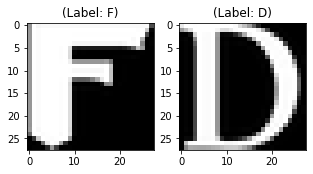

In [14]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [23]:
train_data = train_data.reshape(-1,28,28,1)
test_data = test_data.reshape(-1, 28, 28, 1)


In [24]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(noisy_train,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

In [41]:
mean = 0
sigma = 1
noise_factor = 0.5
noisy_train = train_X + noise_factor*np.random.normal(loc=mean, scale=sigma, size=train_X.shape)
noisy_test = test_data + noise_factor*np.random.normal(loc=mean, scale=sigma, size=test_data.shape)
noisy_valid = valid_X + noise_factor*np.random.normal(loc=mean, scale=sigma, size=valid_X.shape)
noisy_train = np.clip(noisy_train, 0., 1.)
noisy_test = np.clip(noisy_test, 0., 1.)
noisy_valid = np.clip(noisy_valid, 0., 1.)

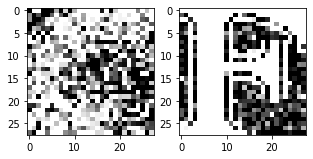

In [42]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(noisy_train[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(noisy_test[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [43]:
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [44]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [45]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [46]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 128)         1475

In [47]:
autoencoder_train = autoencoder.fit(noisy_train, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(noisy_valid, valid_X))


Epoch 1/20
375/375 [==============================] - 6s 14ms/step - loss: 0.1298 - val_loss: 0.1023
Epoch 2/20
375/375 [==============================] - 5s 13ms/step - loss: 0.1012 - val_loss: 0.0937
Epoch 3/20
375/375 [==============================] - 5s 13ms/step - loss: 0.0915 - val_loss: 0.0901
Epoch 4/20
375/375 [==============================] - 5s 13ms/step - loss: 0.0864 - val_loss: 0.0856
Epoch 5/20
375/375 [==============================] - 5s 13ms/step - loss: 0.0837 - val_loss: 0.0829
Epoch 6/20
375/375 [==============================] - 5s 13ms/step - loss: 0.0819 - val_loss: 0.0818
Epoch 7/20
375/375 [==============================] - 5s 13ms/step - loss: 0.0804 - val_loss: 0.0817
Epoch 8/20
375/375 [==============================] - 5s 13ms/step - loss: 0.0792 - val_loss: 0.0812
Epoch 9/20
375/375 [==============================] - 5s 13ms/step - loss: 0.0784 - val_loss: 0.0781
Epoch 10/20
375/375 [==============================] - 5s 13ms/step - loss: 0.0772 - val_lo

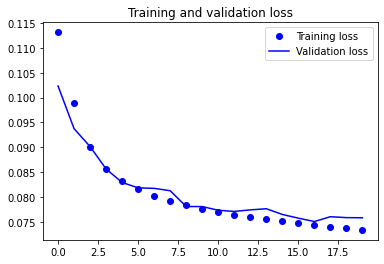

In [48]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [49]:
pred = autoencoder.predict(noisy_test)

Real Image


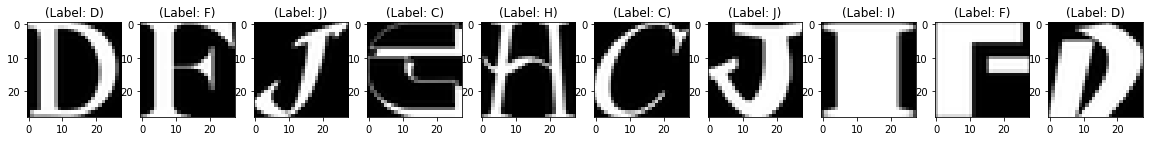

Noisy Images


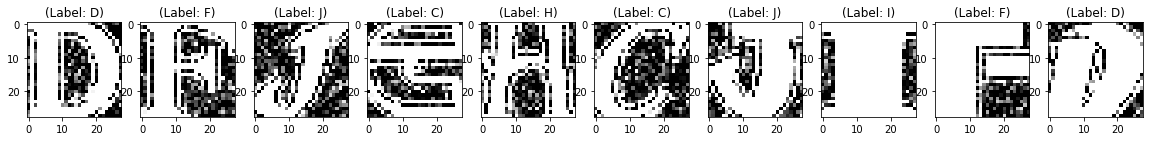

Reconstruction of Test Images


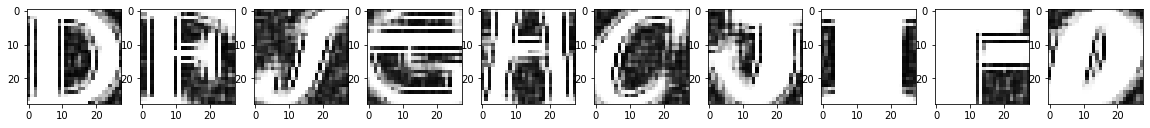

In [50]:
plt.figure(figsize=(20, 4))
print("Real Image")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i].reshape(28,28), cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()   
plt.figure(figsize=(20, 4))
print("Noisy Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(noisy_test[i].reshape(28,28), cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i].reshape(28,28), cmap='gray')  
plt.show()